<a href="https://colab.research.google.com/github/gcochlar/Bootcamp_DataScience/blob/main/Modulo_05/Bootcamp_Mod5_Aula05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://drive.google.com/uc?id=16O9eMrtSeRDnDpZgmneXj34eIClCntvg'>

# ***Machine Learning:*** **Modelos, Métricas e Validação**

---

Esse notebook servirá para o acompanhamento das aulas do Módulo 05 do ***Bootcamp de Data Science Aplicada*** realizado pela Alura.

Este módulo dá continuidade ao trabalho iniciado no Módulo 04, de desenvolvimento de um projeto prático que passa por todo o *workflow* em *Data Science*, do entendimento do problema, tratamento e análise dos dados até a proposta de solução utilizando ***Machine Learning***.

Vamos continuar trabalhando com dados da **COVID-19** do **Hospital Sírio Libanês**, sendo que o foco deste módulo será no aprofundamento dos modelos de ***Machine Learning***, bem como suas métricas e procedimentos de validação de resultados.

---

>No último módulo aplicamos todo nosso conhecimento para analisar dados da COVID-19, entender alguns dos desafios dos hospitais em época de pandemia e propor soluções a partir das análises de dados.
>
>Nossa proposta de solução foi utilizar modelos de Machine Learning, mas para tornar isso possível precisamos aprofundar nossos conhecimentos nesta área, testando modelos mais avançados, utilizando métricas adequadas ao problema e validando de forma correta. Neste módulo vamos trabalhar todas estas frentes para tornar nossa solução uma proposta viável.

## **Aula 01 -** ***Workflow*** **de** ***Machine Learning***
---


Thiago começou a aula falando do ciclo, do *workflow* de **Machine Learning**.

* Definir o objetivo do estudo e o impacto no negócio
* Fazer a aquisição e a transformação dos dados (*datawarehouse*, *data lake*)
* Desenvolvimento do modelo (análise exploratória, treino e teste do modelo)
* Comunicação dos Resultados (melhor modelo encontrado pode não ser suficiente, o impacto econômico ou no negócio pode ser inadequado, a performance pode ser insuficiente, ...)
* Fazer o *deploy* e começar monitoramento (fase onde fica disponível para o usuário)

Na sequência, retomamos o uso do **Colab** como ferramenta, o que eu já vinha fazendo.

Vamos retomar parcialmente o código do módulo passado, em que importamos os dados e fizemos a limpeza inicial, para poder passar a trabalhar em cima dos modelos que queremos treinar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.tree import export_graphviz
from sklearn.tree import export_text
import graphviz

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, plot_roc_curve

In [2]:
url = 'https://github.com/gcochlar/Bootcamp_DataScience/blob/main/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

In [3]:
dados = pd.read_excel(url)
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

Vamos seguir a estratégia adotada no módulo passado, de preencher as lacunas de dados usando os métodos de **```backfill```** e **```forward fill```**.

Precisamos também eliminar os dados dos pacientes que entraram no hospital e já foram para a UTI na primeira janela de medições (0-2h), pois as medições podem ter sido realizadas quando ele já estava na UTI, tornando o resultado sem importância para efeitos preditivos.


In [4]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [5]:
dados_limpos = preenche_tabela(dados)
a_remover = dados_limpos.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos = dados_limpos.dropna()
dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1760.000000,1760.000000,1760.000000,1760.00000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,...,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000,1760.000000
mean,192.818182,0.457386,0.380682,0.11250,0.026136,0.101705,0.021591,0.132955,0.049432,0.212500,0.163636,0.828977,0.517913,0.517913,0.517913,0.517913,-1.0,-0.958386,-0.958386,-0.958386,-0.958386,-1.0,-0.926916,-0.926916,-0.926916,-0.926916,-1.0,-0.306430,-0.306430,-0.306430,-0.306430,-1.0,-0.305377,-0.305377,-0.305377,-0.305377,-1.0,-0.945935,-0.945935,-0.945935,...,-0.955277,-0.955277,-1.0,-0.073908,-0.339631,-0.267838,-0.458545,0.067973,0.747996,-0.078023,-0.344698,-0.270867,-0.452606,0.064864,0.751914,-0.001207,-0.187010,-0.243988,-0.469278,0.350887,0.841908,-0.248728,-0.432592,-0.313034,-0.381784,-0.017968,0.808029,-0.799862,-0.785938,-0.804580,-0.778209,-0.823458,-0.915593,-0.828593,-0.774857,-0.854690,-0.788155,-0.824412,-0.915552,0.201705
std,110.637724,0.498322,0.485692,0.31607,0.159586,0.302345,0.145385,0.339622,0.216829,0.409193,0.370050,0.376636,0.235219,0.235219,0.235219,0.235219,0.0,0.182797,0.182797,0.182797,0.182797,0.0,0.178947,0.178947,0.178947,0.178947,0.0,0.107783,0.107783,0.107783,0.107783,0.0,0.120988,0.120988,0.120988,0.120988,0.0,0.088861,0.088861,0.088861,...,0.125227,0.125227,0.0,0.248552,0.261409,0.241648,0.207736,0.239760,0.119912,0.254493,0.264516,0.247132,0.218765,0.247949,0.119985,0.270201,0.261183,0.260190,0.252147,0.193029,0.236797,0.246389,0.258776,0.274449,0.356890,0.262440,0.132323,0.322680,0.356078,0.324716,0.411909,0.276279,0.247695,0.287696,0.368311,0.240338,0.384405,0.274953,0.248093,0.401387
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Além disso, vamos ficar com apenas uma linha de dados por paciente. Para isso vamos trazer a informação de necessidade de transferência para a UTI para a primeira janela de observação e desprezar as informações das demais.

In [6]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)

dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

In [7]:
x_columns = dados.describe().columns
for coluna in dados.columns:
    if coluna not in x_columns:
        print(coluna)

AGE_PERCENTIL
WINDOW


O método que usamos no módulo passado para selecionar as colunas de dados que irão alimentar nosso modelo levou a desprezar a coluna **```AGE_PERCENTIL```**, por estar no formato *string*.

Vamos converter os dados para categóricos, de forma que nosso modelo possa considerar essas informações também.

In [8]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype("category").cat.codes
dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.9

In [9]:
np.random.seed(73246)

x_columns = dados.columns
y = dados_limpos['ICU']
x = dados_limpos[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo_dummy = DummyClassifier()
#modelo_dummy = DummyClassifier(strategy='prior')
modelo_dummy.fit(x_train, y_train)

y_prediction = modelo_dummy.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [10]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

Essa primeira aula, além da discussão teórica a respeito do *workflow*, serviu mais para organizar nosso *dataset* para o uso ao longo do módulo.

#### **Desafio - Transformar a Coluna `AGE_PERCENTIL` em Dados Categóricos, Utilizando Outro Método**
---



Usei a mesma solução que já tinha utilizado no módulo 4, quando fui investigar quais as colunas que não tinham impacto no resultado do modelo.

Em vez de torná-los categóricos, simplesmente converti para numéricos, levando os modelos a ter o mesmo resultado.

Estranhamente, como já havia constatado antes, o uso da coluna **```AGE_PERCENTIL```** reduz a acurácia do modelo de Regressão Logística.

In [11]:
dados_limpos_desafio = preenche_tabela(dados)
a_remover = dados_limpos_desafio.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos_desafio = dados_limpos_desafio.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos_desafio = dados_limpos_desafio.dropna()

dados_limpos_desafio = dados_limpos_desafio.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)

dados_limpos_desafio['AGE_PERCENTIL'] = dados_limpos_desafio['AGE_PERCENTIL'].str.replace('th', '')
dados_limpos_desafio['AGE_PERCENTIL'] = dados_limpos_desafio['AGE_PERCENTIL'].str.replace('Above ', '')
dados_limpos_desafio['AGE_PERCENTIL'] = dados_limpos_desafio['AGE_PERCENTIL'].astype('int8')

np.random.seed(73246)

x_columns = dados_limpos_desafio.columns
y = dados_limpos_desafio['ICU']
x = dados_limpos_desafio[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
#modelo = DummyClassifier(strategy='prior')
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [12]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6931818181818182

Como o Thiago sugeriu usar o próprio **```sklearn```** para fazer essa conversão, verifiquei a documentação de pré-processamento para achar a função **```LabelEncoder```** que faz exatamente isso.

Apliquei abaixo e obtive os mesmos resultados dos modelos.

In [13]:
dados_limpos_desafio = preenche_tabela(dados)
a_remover = dados_limpos_desafio.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos_desafio = dados_limpos_desafio.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos_desafio = dados_limpos_desafio.dropna()

dados_limpos_desafio = dados_limpos_desafio.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
le = preprocessing.LabelEncoder()
dados_limpos_desafio.AGE_PERCENTIL = le.fit_transform(dados_limpos_desafio.AGE_PERCENTIL)

np.random.seed(73246)

x_columns = dados_limpos_desafio.columns
y = dados_limpos_desafio['ICU']
x = dados_limpos_desafio[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
#modelo = DummyClassifier(strategy='prior')
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [14]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

### **O que aprendemos nessa aula?**
---

>* Qual é um possível **Workflow** em um projeto de **Data Science**;
>
>* Realizar uma transformação de dados em dados categóricos;
>
>* Aumentar o número de iterações da regressão logística para convergir.

---


## **Aula 02 - Métricas de Avaliação**
---


### Vídeo 01 - Matriz de Confusão

Antes de entrar na aula propriamente dita foi lançado um novo desafio que está ao final dessa aula.

Na sequência, vamos trabalhar com um novo tipo de modelo, de **Árvore de Decisão**.

In [15]:
#np.random.seed(73246)

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_train, y_train)
predicao_arvore = modelo_arvore.predict(x_test)
accuracy_score(y_test, predicao_arvore)

0.6590909090909091

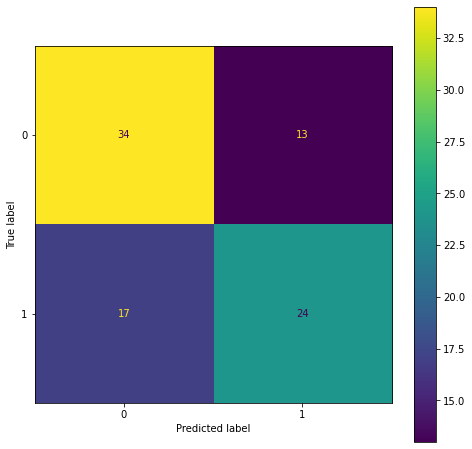

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(modelo_arvore, x_test, y_test, ax=ax)

Vamos ao entendimento da matriz de confusão que foi plotada.

Ela nos indica no eixo **X** quais foram as previsões do nosso modelo e no eixo **Y** quais eram os reais valores da base de teste.

Sendo assim, tivemos os seguintes resultados:
* **Verdadeiro Positivo:** 24 pacientes
* **Verdadeiro Negativo:** 34 pacientes
* **Falso Positivo:** 13 pacientes
* **Falso Negativo:** 17 pacientes

In [17]:
print(classification_report(y_test, predicao_arvore))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



Vamos ao entendimento das colunas do **```classification_report```**:
* ***precision:*** utilizado em casos em que o falso positivo é pior que o falso negativo, indica a precisão com que acertamos o resultado. Dos 51 casos que o modelo previu ZERO (34 + 17), tivemos 34 acertos (66,7%). Dos 37 casos que o modelo previu UM (24 + 13), tivemos 24 acertos (64,9%). É indicado para um caso de análise de investimentos, por exemplo.
* ***recall:*** é indicado para casos em que o falso negativo é muito pior que o falso positivo, como no exemplo de previsão da necessidade de internação em UTI que estamos trabalhando no presente estudo. Dos 47 casos negativos (34 + 13) o modelo acertou 34 (72,3%). Dos 41 casos positivos (17 + 24) o modelo acertou 24 (58,5%).
* ***f1-score:*** é uma média harmônica das métricas anteriores. Isso faz com que tenhamos um peso maior caso haja um desbalanço entre as duas métricas. A fórmula para calculá-lo é:
 * **f1-score = 2 * (precisão * recall) / (precisão + recall)**

#### **Desafio - Verificar o Impacto da Mudança da Coluna ```AGE_PERCENTIL``` nos Resultados**
---

Eui já havia feito essa avaliação no final da aula passada, inclusive achei estranho o fato da eficácia do modelo ter caído depois da alteração.

Outro ponto que foi levantado é a possibilidade de estarmos atribuindo um peso maior a essa variável, pois enquanto a maioria das demais variáveis variam entre -1 e 1, essa categoria vai de 0 até 9. A diferença não é significativa, isso poderia ser um ponto importante se a categoria variasse na casa dos milhares ou valores maiores.

De qualquer forma, pretendo fazer esse desafio alterando os valores da variável para o *range* de -1 a 1 e avaliar o novo resultado.

Como temos 10 possíveis valores, acredito que a maneira mais simples é fazer a alteração via dicionário, atribuindo valores -1 para 0 e 1 para 9. Com isso, os demais números vão variar a cada 0,22.


In [18]:
dict_age = {0:-1, 1:-0.78, 2:-0.56,
            3:-0.34, 4:-0.12, 5:0.1,
            6:0.32, 7:0.54, 8:0.76, 9:1}

dados_limpos_desafio = preenche_tabela(dados)
a_remover = dados_limpos_desafio.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos_desafio = dados_limpos_desafio.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_limpos_desafio = dados_limpos_desafio.dropna()

dados_limpos_desafio = dados_limpos_desafio.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
le = preprocessing.LabelEncoder()
dados_limpos_desafio.AGE_PERCENTIL = le.fit_transform(dados_limpos_desafio.AGE_PERCENTIL)
dados_limpos_desafio.AGE_PERCENTIL = dados_limpos_desafio.AGE_PERCENTIL.map(dict_age)

In [19]:
np.random.seed(73246)

x_columns = dados_limpos_desafio.columns
y = dados_limpos_desafio['ICU']
x = dados_limpos_desafio[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
modelo = DummyClassifier()
#modelo = DummyClassifier(strategy='prior')
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [20]:
modelo = LogisticRegression(max_iter=10000)
modelo.fit(x_train, y_train)

y_prediction = modelo.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

Como pode ser visto, a troca dos dados categóricos da coluna **```AGE_PERCENTIL```** que variavam entre 0 e 9 para o intervalo de -1 a 1 não alterou a acurácia dos modelos.

#### **Desafio - Pesquisar Sobre o** ***F-Score***
---

O ***F-Score*** é uma medida de acurácia que combina os resultados de ***precision*** e ***recall*** na forma de média harmônica.

Usualmente (e é o caso que pode ser visto no **`classification_report`**), utilizamos o ***F1-Score***, que traz um resultado mais equilibrado entre as duas métricas.

Caso o objetivo seja dar ênfase ao resultado de ***precision*** pode-se usar o ***F0,5-Score***. Se o objetivo é dar ênfase ao resultado de ***recall***, usamos o ***F2-Score***.

A fórmula do ***F-Score*** é:
$$ F(\beta) = \frac{(1 + \beta^2) * precision * recall}{(\beta^2 * precision) + recall} $$

A maneira mais fácil de identificar essa relação é com exemplos. Se temos um modelo que apresenta um resultado de ***precision*** de 0,5 e ***recall*** de 1, teremos os seguintes ***F-Scores***:
* **F1-Score** = 0,667 ==> média harmônica das métricas
* **F2-Score** = 0,833 ==> ênfase em ***recall***
* **F0,5-Score** = 0,555 ==> ênfase em ***precision***

Fontes:
* [Wikipedia](https://en.wikipedia.org/wiki/F-score)
* [Towards Data Science](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9)
* [Machine Learning Mastery](https://machinelearningmastery.com/fbeta-measure-for-machine-learning/)
* [DeepAI](https://deepai.org/machine-learning-glossary-and-terms/f-score)


#### **Desafio - Pesquisar e Plotar a Árvore de Decisão Criada pelo Modelo**
---

Primeiramente da maneira mais simples (e com uma apresentação mais pobre).

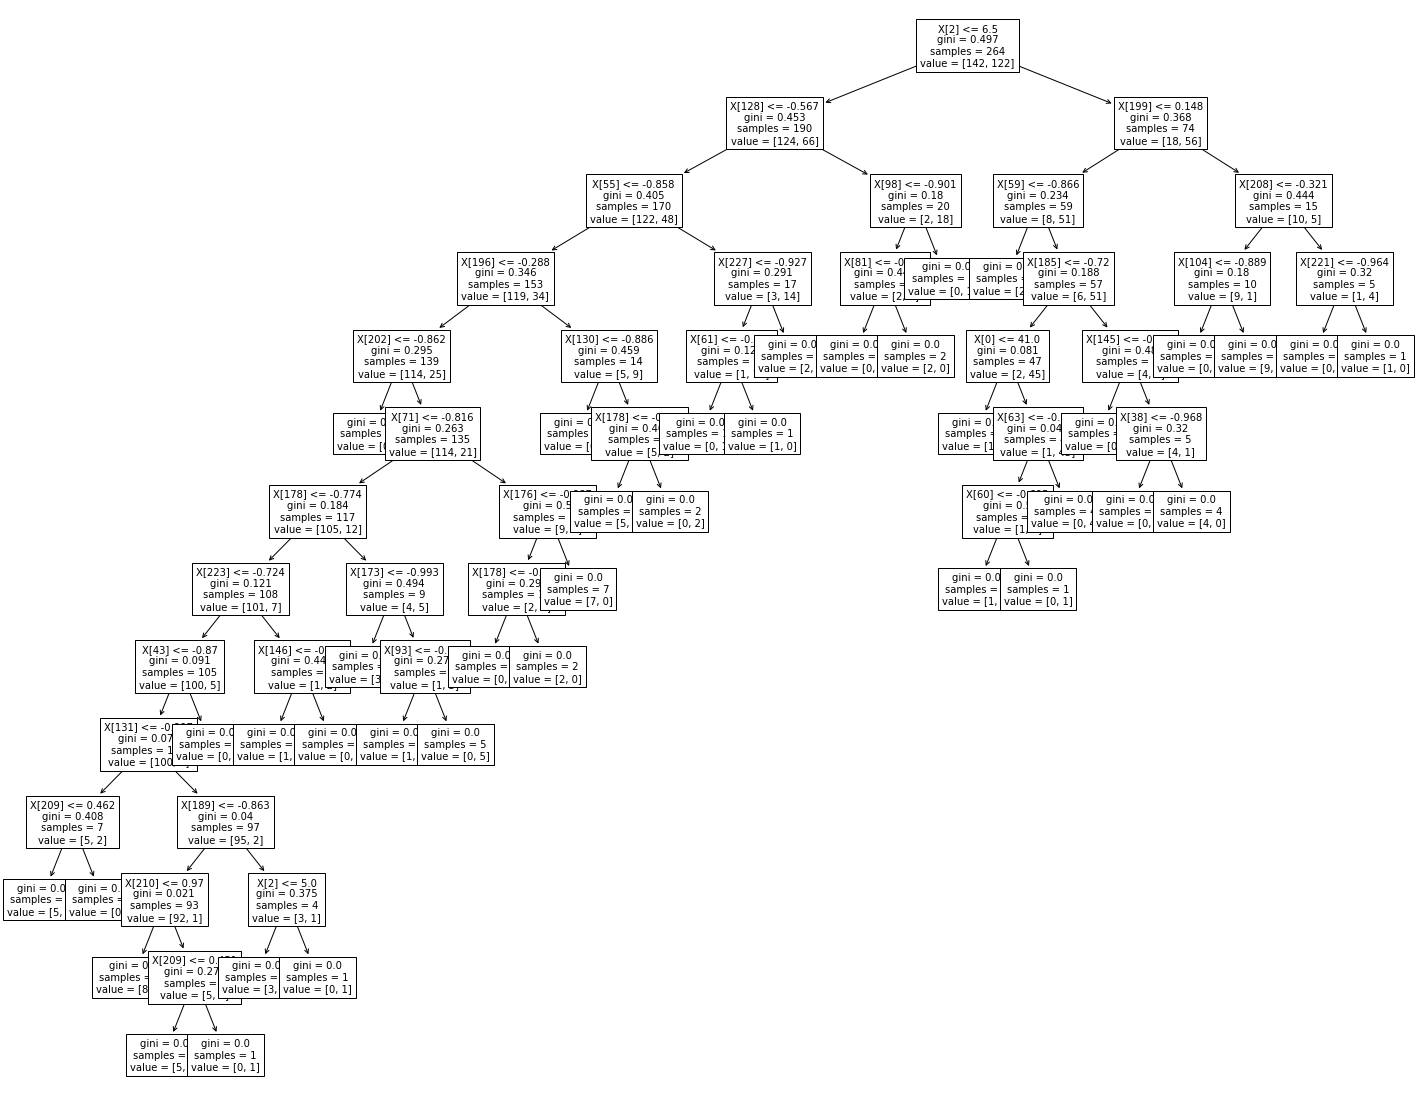

In [21]:
fig = plt.figure(figsize = (25,20))

plot_tree(modelo_arvore,fontsize= 10)

plt.show()

Agora vamos passar para uma apresentação mais rica visualmente, onde temos os nomes das variáveis, o percentual de amostras que seguiu por cada galho e cores indicando p resultado predominante nos caminhos seguidos .

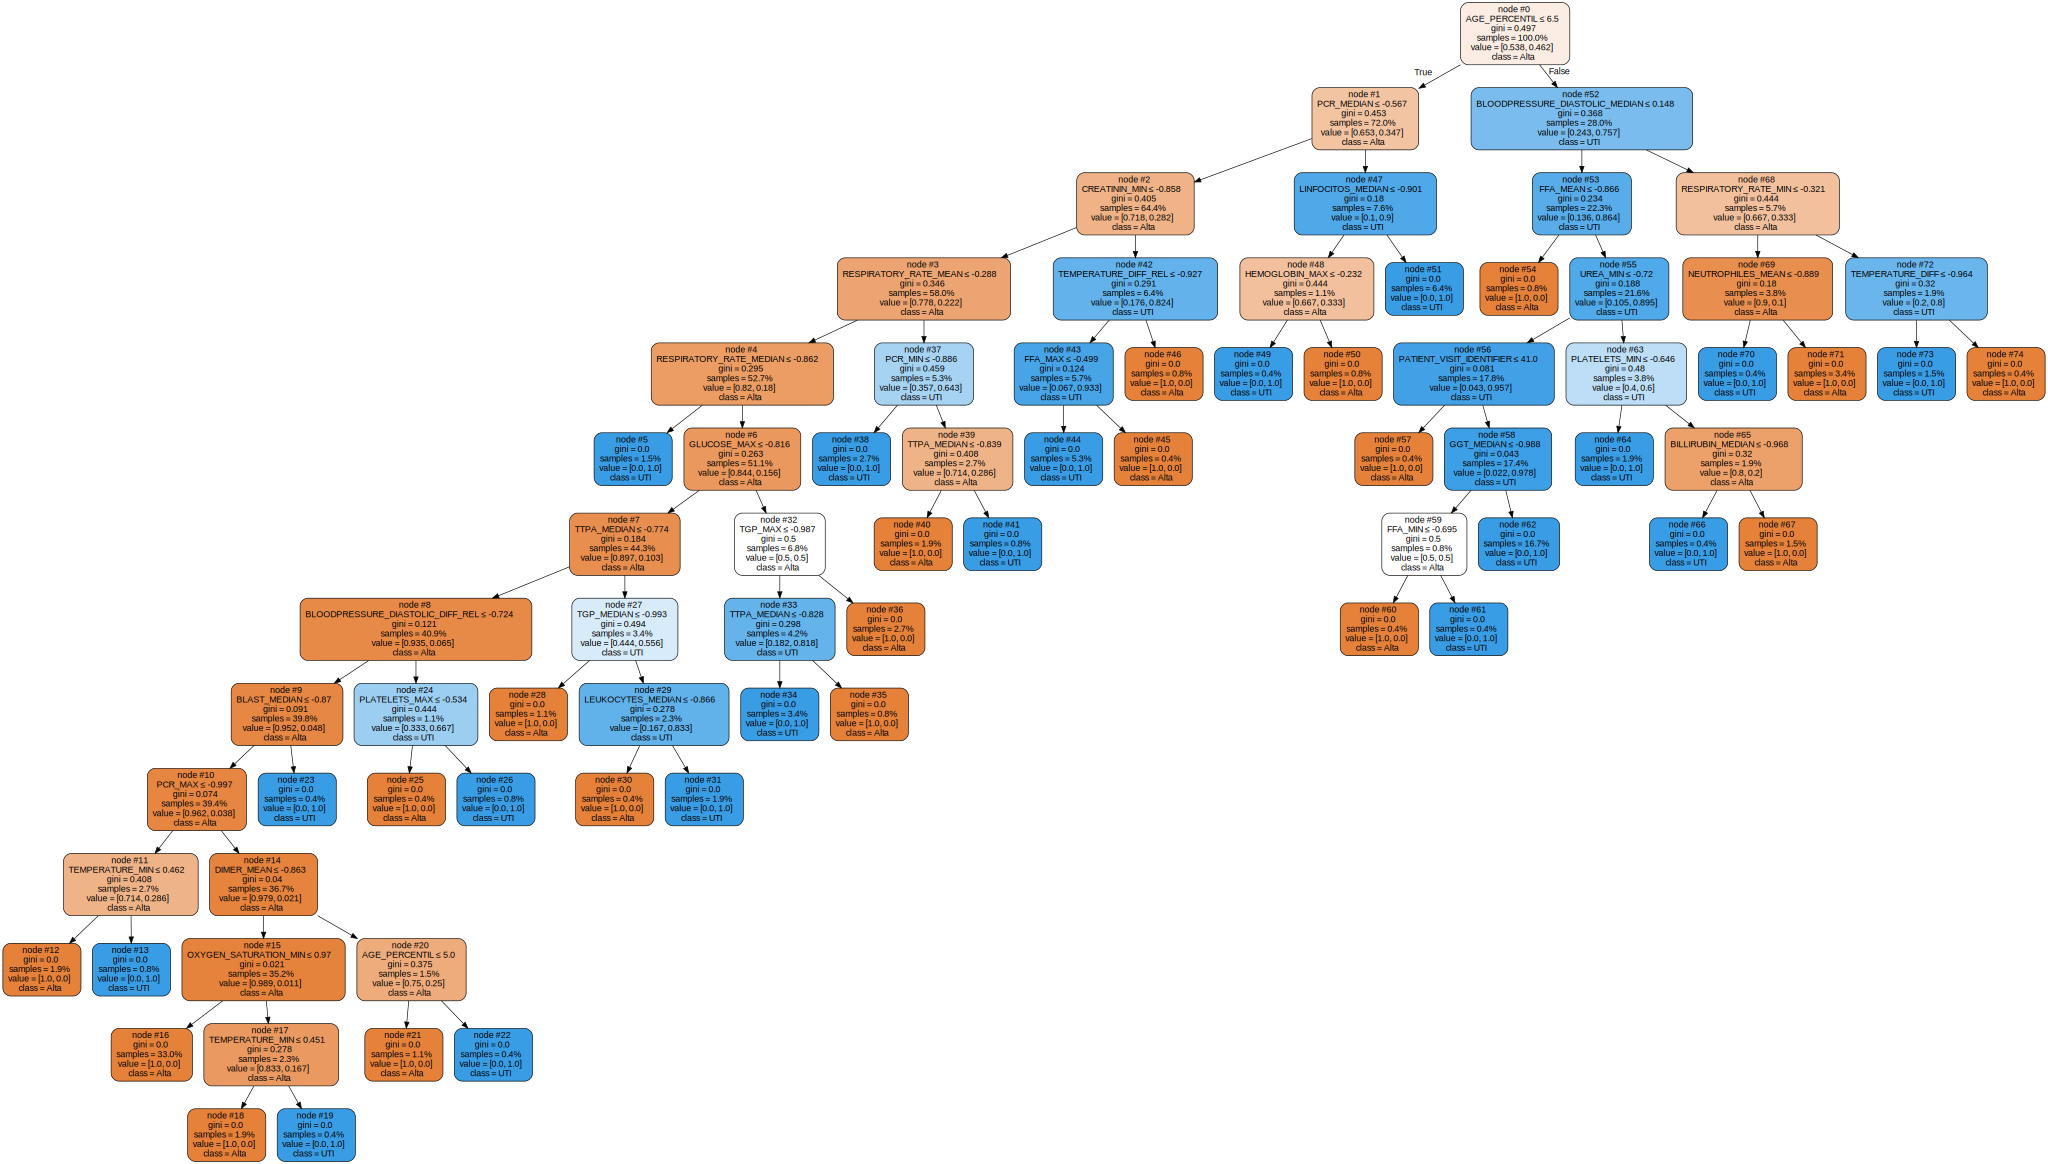

In [22]:
arvore = export_graphviz(modelo_arvore,
                         out_file = None, max_depth = None,
                         feature_names = x.columns,
                         class_names = ['Alta', 'UTI'], label = 'all',
                         filled = True, leaves_parallel = False,
                         impurity = True, node_ids = True,
                         proportion = True, rotate = False,
                         rounded = True, special_characters = True,
                         precision = 3)
plot_arvore = graphviz.Source(arvore, format='png')
plot_arvore

In [23]:
lista = dados_limpos[x_columns].drop(['ICU','WINDOW'], axis=1).columns.tolist()

arvore_texto = export_text(modelo_arvore, feature_names=lista,
                           max_depth = 10, spacing = 3,
                           decimals = 3, show_weights = True)
print(arvore_texto)

|--- AGE_PERCENTIL <= 6.500
|   |--- PCR_MEDIAN <= -0.567
|   |   |--- CREATININ_MIN <= -0.858
|   |   |   |--- RESPIRATORY_RATE_MEAN <= -0.288
|   |   |   |   |--- RESPIRATORY_RATE_MEDIAN <= -0.862
|   |   |   |   |   |--- weights: [0.000, 4.000] class: 1
|   |   |   |   |--- RESPIRATORY_RATE_MEDIAN >  -0.862
|   |   |   |   |   |--- GLUCOSE_MAX <= -0.816
|   |   |   |   |   |   |--- TTPA_MEDIAN <= -0.774
|   |   |   |   |   |   |   |--- BLOODPRESSURE_DIASTOLIC_DIFF_REL <= -0.724
|   |   |   |   |   |   |   |   |--- BLAST_MEDIAN <= -0.870
|   |   |   |   |   |   |   |   |   |--- PCR_MAX <= -0.997
|   |   |   |   |   |   |   |   |   |   |--- TEMPERATURE_MIN <= 0.462
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [5.000, 0.000] class: 0
|   |   |   |   |   |   |   |   |   |   |--- TEMPERATURE_MIN >  0.462
|   |   |   |   |   |   |   |   |   |   |   |--- weights: [0.000, 2.000] class: 1
|   |   |   |   |   |   |   |   |   |--- PCR_MAX >  -0.997
|   |   |   |   |   |   |   |   

### Vídeo 02 - Curva ROC e AUC

Começamos com reforço de conceitos:
* ***Precision*** ou Precisão: qual o percentual de realmente positivas dentro do total de classificações positivas feitas pelo modelo (VP / (VP+FP))
* ***Recall*** ou Revocação: qual o percentual de realmente positivas dentro do total de casos positivos que realmente havia na base (VP / (VP+FN))

Daí evoluímos para novos conceitos, da curva ROC e AUC.
* **Curva ROC:** é a curva que plota a taxa de verdadeiros positivos (também chamada de *sensibilidade*) no eixo **Y** e a taxa de falsos positivos (ou *especificidade*) na forma de 1 - especificidade no eixo **X**. Com isso, como podemos ver na imagem abaixo, quanto mais próxima do canto superior esquerdo do gráfico, melhor a qualidade do modelo

<img src='https://upload.wikimedia.org/wikipedia/commons/3/3d/Curva_ROC.svg' width='400px' height='300px'>

* **AUC:** é a *Area Under the Curve*, ou seja, a área medida embaixo da curva ROC plotada. É uma forma objetiva de termos uma comparação entre modelos, o que pode ser difícil de avaliar visualmente no gráfico. Na imagem abaixo, é a área marcada em amarelo.

<img src='https://miro.medium.com/max/700/1*2nd7NTEBosPakccmLVWy9A.png' width='400px' height='300px'>

Em ambas imagens podemos ver uma linha pontilhada na diagonal do gráfico. Essa linha representa a performance esperada de um classificador aleatório. Podemos considerar que a performance de qualquer modelo precisa ser pelo menos superior a isso, ou seja, a curva ROC precisa estar acima dessa diagonal.

Fontes:
* [SANAR](https://www.sanarmed.com/curva-roc-isso-realmente-faz-diferenca-colunistas)
* [Wikipedia](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor)

In [24]:
#np.random.seed(73246)

prob_arvore = modelo_arvore.predict_proba(x_test)
roc_auc_score(y_test, prob_arvore[:,1])

0.5812143227815256

In [25]:
def roda_modelo(modelo, dados):

    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    predicao = modelo.predict(x_test)
    prob_predic = modelo.predict_proba(x_test)

    auc = roc_auc_score(y_test, prob_predic[:,1])
    print(f'AUC {auc}')
    print('\nClassification Report')
    print(classification_report(y_test, predicao))

In [26]:
roda_modelo(modelo_arvore, dados_limpos)

AUC 0.6040477426050858

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.74      0.67        47
           1       0.61      0.46      0.53        41

    accuracy                           0.61        88
   macro avg       0.61      0.60      0.60        88
weighted avg       0.61      0.61      0.61        88



In [27]:
roda_modelo(modelo, dados_limpos)

AUC 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



#### **Desafio - Desenvolver Função que Plote a Curva ROC**
---

Desafio Extra - Plotar as Curvas de Diversos Modelos para Comparação

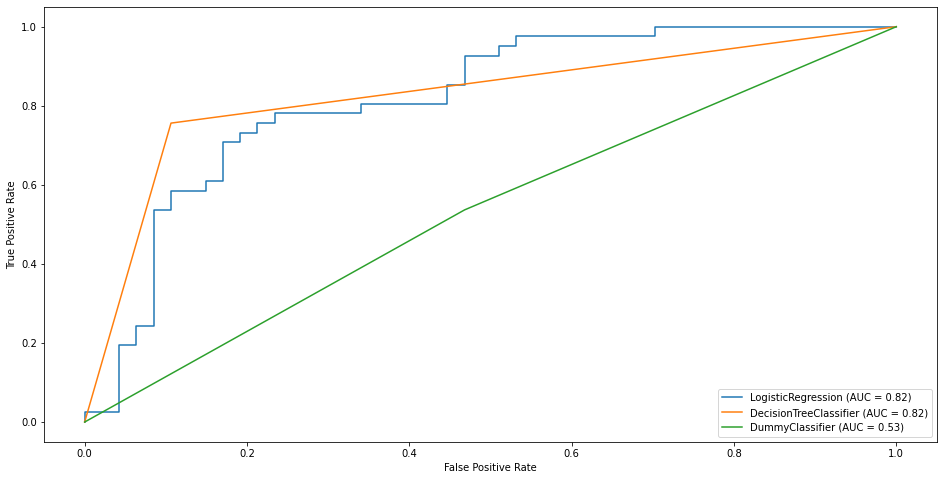

In [28]:
fig, ax = plt.subplots(figsize = (16,8))
plot_roc_curve(modelo, x_test, y_test, ax=ax)
plot_roc_curve(modelo_arvore, x_test, y_test, ax=ax)
plot_roc_curve(modelo_dummy, x_test, y_test, ax=ax)

#### **Desafio - Como Reduzir o Efeito da Aleatoriedade no Comparativo Entre Modelos**
---

Foi solicitado que se trabalhasse uma maneira criativa de reduzir a aleatoriedade dos resultados, sem buscar a documentação, que deve sugerir a maneira mais tradicional que será vista na aula 03.

Tinha pensado em usar o **`random_state`** ao executar o **`train_test_split`** mas pensando melhor acho que isso apenas resolve a questão de termos resultados diferentes a cada execução. Para um determinado **`random_state`** podemos ter um modelo que desempenha melhor e para outro **`random_state`**, uma resposta diferente.

Entendo que o mais correto seria usar a metodologia de validação cruzada que vimos no módulo anterior, pois daí usaremos várias amostras diferentes de dados para treino e teste e teremos como medida final a média dos resultados obtidos.

### **O que aprendemos nessa aula?**
---

>* Como usar uma árvore de decisão;
>
>* Analisar a qualidade dos resultados com a matriz de confusão;
>
>* Gerar um relatório do resultado da classificação;
>
>* O que é *Recall*, *Precision*, *F-Score* e *AUC*.

---


## **Aula 03 - Aleatoriedade de Modelos**
---


A ideia dessa aula é tentar reduzir o impacto da aleatoriedade na escolha dos dados que irão treinar e testar os modelos.

A solução indicada foi definir uma nova função que executa *n* vezes o processo de separação dos dados em treino e teste, treina os modelos e depois calcula a média e o desvio padrão das ***AUCs*** encontradas.

In [29]:
def roda_n_modelos(modelo, dados, n):
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU', 'WINDOW'], axis = 1)

    auc_lista = []

    for _ in range(n):
        x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)

        modelo.fit(x_train, y_train)
        prob_predic = modelo.predict_proba(x_test)
        auc = roc_auc_score(y_test, prob_predic[:,1])
        auc_lista.append(auc)

    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f'Resultados após {n} execuções')
    print(f'AUC Médio {auc_medio}')
    print(f'Intervalo {auc_medio - 2 * auc_std} a {auc_medio + 2 * auc_std}')
    print(f'Range     {2 * auc_std}')

In [30]:
roda_n_modelos(modelo_arvore, dados_limpos, 100)

Resultados após 100 execuções
AUC Médio 0.6276440062272963
Intervalo 0.5385560923038623 a 0.7167319201507304
Range     0.08908791392343408


In [31]:
roda_n_modelos(modelo, dados_limpos, 100)

Resultados após 100 execuções
AUC Médio 0.7575142708873897
Intervalo 0.6621677125209211 a 0.8528608292538582
Range     0.0953465583664685


Com os resultados obtidos podemos ver que o modelo de Regressão Logística apresenta um desempenho melhor que o de Árvore de Decisão, mas me chamou a atenção também a diferença de performance dos modelos.

Para executar 100 vezes o modelo de Árvore de Decisão precisou de aproximadamente 2,5 segundos, enquanto o modelo de Regressão Logística levou mais de 43 segundos. Essa diferença pode ser crítica em bases de dados maiores ou quando for necessário um maior número de execuções.

#### **Desafio - Estudar a Documentação do `sklearn` e Testar Outros Modelos**
---

Identifiquei na documentação do **```sklearn```** outros dois tipos de modelos que poderíamos aplicar ao nosso problema, o **SVC** (*Support Vector Classification*) e o **Random Forest Classifier**.

In [32]:
from sklearn.svm import SVC

In [33]:
mod_svc_linear = SVC(kernel = 'linear', probability = True)

mod_svc_quadrado = SVC(kernel = 'poly', degree = 2, probability = True)

mod_svc_5 = SVC(kernel = 'poly', degree = 5, probability = True)

In [34]:
roda_n_modelos(mod_svc_linear, dados_limpos, 5)

#roda_n_modelos(mod_svc_linear, dados_limpos, 50)

Resultados após 5 execuções
AUC Médio 0.7558380902957965
Intervalo 0.6239358952256842 a 0.8877402853659089
Range     0.1319021950701123


**Imagem do Resultado Obtido com 50 Execuções**

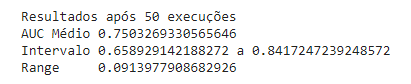

In [35]:
#roda_n_modelos(mod_svc_quadrado, dados_limpos, 5)

roda_n_modelos(mod_svc_quadrado, dados_limpos, 50)

Resultados após 50 execuções
AUC Médio 0.4321224701608719
Intervalo 0.07755744290085831 a 0.7866874974208855
Range     0.3545650272600136


In [36]:
#roda_n_modelos(mod_svc_5, dados_limpos, 5)

roda_n_modelos(mod_svc_5, dados_limpos, 50)

Resultados após 50 execuções
AUC Médio 0.4190088220031136
Intervalo 0.08037757513170929 a 0.757640068874518
Range     0.33863124687140433


O modelo **SVC** apresentou um desempenho fraco de maneira geral. Apesar do **SVC Linear** ter chegado a resultados semelhantes ao da Regressão Logística, levou mais de 7 minutos sendo executado. Inclusive reduzi para execução de apenas 5 vezes, para quando for necessário rodar todo o notebook novamente.

As variações (**SVC Quadrático** e **SVC Polinomial Grau 5**) foram de execução mais rápida mas apresentaram resultados inferiores a 50% com alto desvio padrão.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
mod_RFC = RandomForestClassifier()

In [39]:
roda_n_modelos(mod_RFC, dados_limpos, 100)

Resultados após 100 execuções
AUC Médio 0.7861261027503892
Intervalo 0.7042545924155176 a 0.8679976130852608
Range     0.08187151033487158


Considero que o ***Random Forest Classifier*** apresentou um bom desempenho, tanto em termos de tempo de execução quanto em termos de **AUC** encontrado.

Até agora, foi o melhor desempenho obtido.

In [40]:
mod_svc_linear_b = SVC(kernel = 'linear', probability = True, C = 0.025)

mod_svc_5b = SVC(kernel = 'poly', degree = 3, probability = True, gamma = 2, C = 0.025)

#mod_svc_5b = SVC(kernel = 'poly', degree = 3, probability = True, gamma = 2, C = 1)

In [41]:
roda_n_modelos(mod_svc_linear_b, dados_limpos, 50)

Resultados após 50 execuções
AUC Médio 0.7759885832900882
Intervalo 0.6921398883429932 a 0.8598372782371833
Range     0.08384869494709503


In [42]:
#roda_n_modelos(mod_svc_5b, dados_limpos, 2)

Olhando nos exemplos da documentação do **SVC** eu vi esses parâmetros alterados para os modelos linear (`C`) e polinomial (`C` e `gamma`) e resolvi testar mais essas duas parametrizações.

O modelo linear trouxe praticamente os mesmos resultados de **AUC** em apenas 11 segundos (contra os mais de 7 minutos anteriormente).

Já o modelo polinomial, com esses parâmetros, não rodou. Tentei reduzir para rodar apenas 2 vezes e mesmo assim ele atingia o tempo limite de conexão e me derrubava do **Colab**. Não vou conseguir testar esse modelo.

### **O que aprendemos nessa aula?**
---

>* Como criar uma função para treinar N vezes seu modelo;
>
>* Como a aleatoriedade interfere na sua escolha;
>
>* Cálculo do intervalo mínimo e máximo para a métrica **AUC**;
>
>* Como reduzir o efeito de aleatoriedade na tomada de decisão.

---


## **Aula 04 - Validação Cruzada**
---


Nessa aula vamos retomar a estratégia da validação cruzada que vimos no módulo 03. Nela nós separamos o nosso *dataset* em diversos pedaços e repetimos o *fit* do modelo diversas vezes, alternando os pedaços que usamos para teste, como podemos ver na figura abaixo.

<img src='https://drive.google.com/uc?id=1mx-L_8WfwNYRKea5hWS8-LWQqfXrP91X' width='500px' height='300px'>

No exemplo, a base de dados é dividida em 5 blocos e, a cada execução, o bloco em cinza é usado para testes, obtendo acurácias diferentes. O resultado do modelo será a média das acurácias obtidas.

In [43]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

In [44]:
cv = StratifiedKFold(n_splits = 5, shuffle = True)

result = cross_validate(modelo, x, y, cv = cv)
result

{'fit_time': array([0.19399142, 0.60844517, 0.52904177, 0.46822214, 0.50854588]),
 'score_time': array([0.00215507, 0.00212312, 0.00212455, 0.00212145, 0.00213742]),
 'test_score': array([0.70422535, 0.74647887, 0.7       , 0.74285714, 0.68571429])}

In [45]:
cv = StratifiedKFold(n_splits = 5, shuffle = True)

result = cross_validate(modelo_arvore, x, y, cv = cv)
result

{'fit_time': array([0.02831101, 0.02615476, 0.02589297, 0.02432323, 0.01709604]),
 'score_time': array([0.00190139, 0.00182128, 0.00178909, 0.00121546, 0.00117683]),
 'test_score': array([0.46478873, 0.61971831, 0.62857143, 0.65714286, 0.58571429])}

In [46]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [47]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

result = cross_validate(modelo, x, y, cv = cv)
result

{'fit_time': array([0.61707425, 0.5097785 , 0.58063769, 0.27139878, 0.23765278,
        0.13864207, 0.47961116, 0.49119329, 0.56550312, 0.43275928,
        0.54978752, 0.55624771, 0.17558503, 0.53327131, 0.50319123,
        0.52230191, 0.58933282, 0.25411367, 0.5851593 , 0.52120233,
        0.1550703 , 0.54764771, 0.5055635 , 0.24653506, 0.50867677,
        0.66844559, 0.18199086, 0.47042346, 0.54405904, 0.63929558,
        0.17560291, 0.49385524, 0.5219965 , 0.55471301, 0.48780227,
        0.50622296, 0.2615397 , 0.21615744, 0.19315052, 0.22302818,
        0.54567146, 0.21919847, 0.20917749, 0.52199149, 0.17451239,
        0.53180122, 0.52549815, 0.58402491, 0.2510848 , 0.54513812]),
 'score_time': array([0.00214934, 0.00212359, 0.00211835, 0.00210142, 0.00212288,
        0.00196075, 0.00211048, 0.00209284, 0.01014185, 0.00214887,
        0.00213456, 0.00213861, 0.00206685, 0.00215983, 0.00212741,
        0.00214911, 0.00215554, 0.00212288, 0.00212526, 0.00214624,
        0.00211906, 

In [48]:
result['test_score'].std()

0.04920465096515651

In [49]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)

    dados = dados.sample(frac = 1).reset_index(drop = True)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    result = cross_validate(modelo, x, y, cv = cv, scoring = 'roc_auc')

    auc_medio = result['test_score'].mean()
    auc_std = result['test_score'].std()

    print(f'AUC Médio {auc_medio}')
    print(f'Intervalo {auc_medio - 2 * auc_std} a {auc_medio + 2 * auc_std}')
    print(f'Range     {2 * auc_std}')

In [50]:
roda_modelo_cv(modelo, dados_limpos, 5, 10)

AUC Médio 0.757641695223932
Intervalo 0.6355431542339184 a 0.8797402362139456
Range     0.12209854099001365


In [51]:
roda_modelo_cv(modelo_arvore, dados_limpos, 5, 10)

AUC Médio 0.6279279683391525
Intervalo 0.4988394445682657 a 0.7570164921100394
Range     0.12908852377088686


In [52]:
roda_modelo_cv(mod_RFC, dados_limpos, 5, 10)

AUC Médio 0.7939557739557739
Intervalo 0.7055497813730257 a 0.882361766538522
Range     0.08840599258274821


#### **Desafio - Testar Outras `splitter_classes` e Observar as Diferenças**
---


##### ***StratifiedShuffleSplit***
---


In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

In [54]:
cv = StratifiedShuffleSplit(n_splits = 5)

result = cross_validate(modelo, x, y, cv = cv, scoring = 'roc_auc')
auc_medio = result['test_score'].mean()
auc_std = result['test_score'].std()

print(f'AUC Médio {auc_medio}')
print(f'Intervalo {auc_medio - 2 * auc_std} a {auc_medio + 2 * auc_std}')
print(f'Range     {2 * auc_std}')

AUC Médio 0.8334365325077397
Intervalo 0.7122640011651014 a 0.9546090638503781
Range     0.12117253134263843


In [55]:
cv = StratifiedShuffleSplit(n_splits = 5)

result = cross_validate(modelo_arvore, x, y, cv = cv, scoring = 'roc_auc')
auc_medio = result['test_score'].mean()
auc_std = result['test_score'].std()

print(f'AUC Médio {auc_medio}')
print(f'Intervalo {auc_medio - 2 * auc_std} a {auc_medio + 2 * auc_std}')
print(f'Range     {2 * auc_std}')

AUC Médio 0.609907120743034
Intervalo 0.44510349975087904 a 0.774710741735189
Range     0.16480362099215498


### **O que aprendemos nessa aula?**
---

>* O que é Validação Cruzada;
>
>* Como usar a Validação Cruzada do **`Sci-Kit Learn`**;
>
>* Qual Validação Cruzada usar no nosso caso de estudo.

---


## **Aula 05 - Desafios em** ***Machine Learning***
---


Um dos pontos a ser analisado nessa aula é o *overfitting*, em que o modelo fica muito bem adaptado aos dados de treino mas não consegue fazer um bom trabalho de previsão para dados novos.

Vamos alterar alguns parâmetros do nosso modelo de Árvore de Decisão, consultando a documentação.
[***Decision Tree***](https://scikit-learn.org/stable/modules/tree.html)

Um dos primeiros parâmetros que pode ser alterado é o **`max_depth`**, que determina a profundidade máxima que nossa árvore vai atingir.

In [56]:
modelo_arvore_d3 = DecisionTreeClassifier(max_depth=3)
modelo_arvore_d4 = DecisionTreeClassifier(max_depth=4)
modelo_arvore_d5 = DecisionTreeClassifier(max_depth=5)
modelo_arvore_d6 = DecisionTreeClassifier(max_depth=6)

In [57]:
print('\nModelo Árvore - Depth = 3')
roda_modelo_cv(modelo_arvore_d3, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 4')
roda_modelo_cv(modelo_arvore_d4, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 5')
roda_modelo_cv(modelo_arvore_d5, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 6')
roda_modelo_cv(modelo_arvore_d6, dados_limpos, 5, 10)


Modelo Árvore - Depth = 3
AUC Médio 0.6643847795163584
Intervalo 0.5408496038380549 a 0.787919955194662
Range     0.1235351756783035

Modelo Árvore - Depth = 4
AUC Médio 0.6554932930837536
Intervalo 0.5297661979528577 a 0.7812203882146495
Range     0.1257270951308959

Modelo Árvore - Depth = 5
AUC Médio 0.6475058192163456
Intervalo 0.5011322213480258 a 0.7938794170846655
Range     0.14637359786831977

Modelo Árvore - Depth = 6
AUC Médio 0.6239047951959137
Intervalo 0.46637314891829074 a 0.7814364414735366
Range     0.15753164627762292


Podemos ver que, após uma melhora inicial em relação ao modelo em que não havíamos passado o parâmetro, a partir de **`max_depth = 5`** a acurácia volta a cair...

Vamos alterar nossa função **`roda_modelo_cv`** para nos fornecer também o **AUC** dos dados de treinamento, para entender melhor o comportamento dos modelos.

In [58]:
def roda_modelo_cv_v2(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)

    dados = dados.sample(frac = 1).reset_index(drop = True)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    result = cross_validate(modelo, x, y, cv = cv, scoring = 'roc_auc', return_train_score = True)

    auc_medio = result['test_score'].mean()
    auc_medio_treino = result['train_score'].mean()
    auc_std = result['test_score'].std()
    auc_std_treino = result['train_score'].std()

    print(f'==AUC Médio {auc_medio}')
    print(f'==Intervalo {auc_medio - 2 * auc_std} a {auc_medio + 2 * auc_std}')
    print(f'==Range     {2 * auc_std}')
    print(f'\n===AUC Médio de Treino {auc_medio_treino}')
    print(f'===Intervalo {auc_medio_treino - 2 * auc_std_treino} a {auc_medio_treino + 2 * auc_std_treino}')
    print(f'===Range     {2 * auc_std_treino}')

In [59]:
print('\nModelo Árvore - Depth = 3')
roda_modelo_cv_v2(modelo_arvore_d3, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 4')
roda_modelo_cv_v2(modelo_arvore_d4, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 5')
roda_modelo_cv_v2(modelo_arvore_d5, dados_limpos, 5, 10)
print('\nModelo Árvore - Depth = 6')
roda_modelo_cv_v2(modelo_arvore_d6, dados_limpos, 5, 10)


Modelo Árvore - Depth = 3
==AUC Médio 0.6643847795163584
==Intervalo 0.5408496038380549 a 0.787919955194662
==Range     0.1235351756783035

===AUC Médio de Treino 0.8243714304989842
===Intervalo 0.7927219045021597 a 0.8560209564958087
===Range     0.031649525996824475

Modelo Árvore - Depth = 4
==AUC Médio 0.6554932930837536
==Intervalo 0.5297661979528577 a 0.7812203882146495
==Range     0.1257270951308959

===AUC Médio de Treino 0.8832038893699776
===Intervalo 0.8487939503147206 a 0.9176138284252346
===Range     0.03440993905525705

Modelo Árvore - Depth = 5
==AUC Médio 0.6475058192163456
==Intervalo 0.5011322213480258 a 0.7938794170846655
==Range     0.14637359786831977

===AUC Médio de Treino 0.9275331115338461
===Intervalo 0.8963003095675415 a 0.9587659135001507
===Range     0.031232801966304676

Modelo Árvore - Depth = 6
==AUC Médio 0.6239047951959137
==Intervalo 0.46637314891829074 a 0.7814364414735366
==Range     0.15753164627762292

===AUC Médio de Treino 0.9567921210944048
==

Podemos ver que o **AUC** de nossos dados de treino vão aumentando cada vez mais, enquanto o **AUC** geral do modelo começa a cair.

Isso é um indicativo de ***overfitting***, ou seja, nosso modelo está ficando extremamente aderente aos dados de treino, mas com isso reduz a possibilidade de fazer previsões para os dados de teste e dados futuros.

Vamos fazer uma iteração para rodar o modelo com várias profundidades e plotar os resultados de **AUC**.

In [60]:
def roda_modelo_cv_v3(modelo, dados, n_splits, n_repeats):

    np.random.seed(1231234)

    dados = dados.sample(frac = 1).reset_index(drop = True)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    result = cross_validate(modelo, x, y, cv = cv, scoring = 'roc_auc', return_train_score = True)

    auc_medio = result['test_score'].mean()
    auc_medio_treino = result['train_score'].mean()

    return auc_medio, auc_medio_treino

In [61]:
teste_lista = []
treino_lista = []

for i in range(1,15):
    modelo_arvore_i = DecisionTreeClassifier(max_depth=i)
    teste, treino = roda_modelo_cv_v3(modelo_arvore_i, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

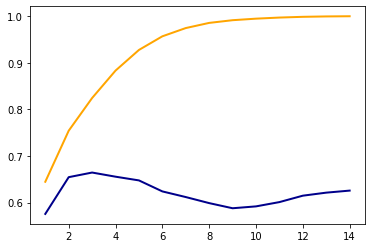

In [62]:
x = range(1,15)
plt.plot(x, teste_lista, color = 'darkblue', lw = 2)
plt.plot(x, treino_lista, color = 'orange', lw = 2)

Podemos ver que a linha laranja, que representa o **AUC** dos nossos dadso de treino se aproxima rapidamente dos 100%. Enquanto isso, a performance do modelo com os dados de teste cai. Isso não ocorre na mesma proporção, mas mostra a piora do modelo de predição.

Nesse caso, temos ***overfitting***.

#### **Desafio - Deixar o Gráfico Bonitão**
---


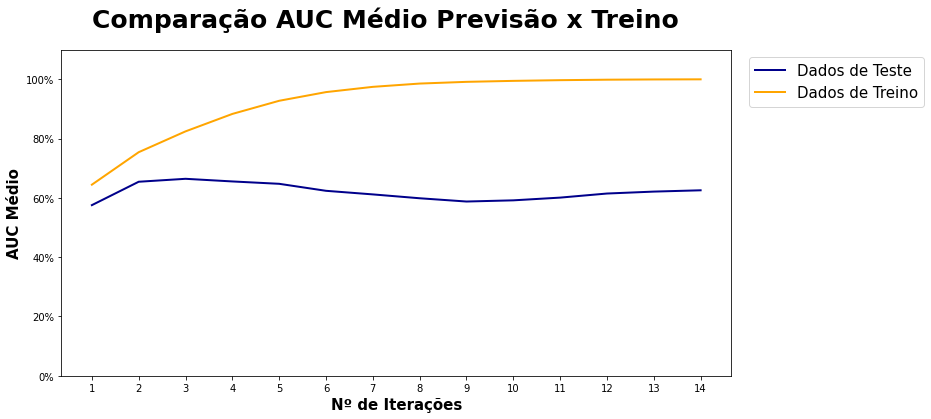

In [63]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(12,6))

plt.suptitle('Comparação AUC Médio Previsão x Treino - Decision Tree', fontsize = 25, fontweight='bold')
plt.plot(x, teste_lista, color = 'darkblue', lw = 2, label='Dados de Teste')
plt.plot(x, treino_lista, color = 'orange', lw = 2, label='Dados de Treino')

plt.xlabel('Nº de Iterações',
             fontsize=15, fontweight = 'bold')
plt.ylabel('AUC Médio',
             fontsize=15, fontweight = 'bold')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.00%}'))
plt.legend(fontsize = 15, loc='upper right',bbox_to_anchor=(1.3, 1))
plt.ylim(0,1.1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

#### **Desafio - Criar Forçadamente um *Overfit* com Outra Base de Dados e Outro Modelo de *Machine Learning*, Plotar Gráficos e Analisar**
---

Sugestão: Base de Dados Titanic do ***Kaggle***

#### **Desafio - Estudar Mais Sobre *Overfit* e *Underfit***
---


Li alguns artigos a respeito, seguem os *links* abaixo.

[IBM.com](https://www.ibm.com/cloud/learn/underfitting)

[Geeks For Geeks](https://www.geeksforgeeks.org/underfitting-and-overfitting-in-machine-learning/)

[Medium - ITBodhi](https://medium.com/@itbodhi/overfitting-and-underfitting-in-machine-learning-models-76cb60dbdaf6)

<img src='https://miro.medium.com/max/560/1*67HOjsCZVzE6FFM7TuSBmw.jpeg'>

<img src='https://miro.medium.com/max/1920/1*Lsg_bRYztO3D19w36_g7BQ.jpeg' width='550px' height='400px'>




#### **De Volta à Aula**
---


O modelo de Árvore de Decisão é poderoso e simples de ser implementado, mas tende a ser suscetível a ***overfit***.

Um modelo alternativo, menos suscetível a ***overfit*** é o **`RandomForestClassifier`**, que simula uma floresta de árvores de decisão.

Enquanto o ***Decision Tree*** busca selecionar os dados que vão ser usados para fazer os *splits* de forma a manter o equilíbrio da árvore, olhando para todas as variáveis, o modelo de ***Random Forest*** monta grupos menores de variáveis de forma aleatória e prepara várias árvores a partir desses grupos diferentes.

In [71]:
teste_lista = []
treino_lista = []

for i in range(1,15):
    modelo_arvore_i = RandomForestClassifier(max_depth=i)
    teste, treino = roda_modelo_cv_v3(modelo_arvore_i, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)

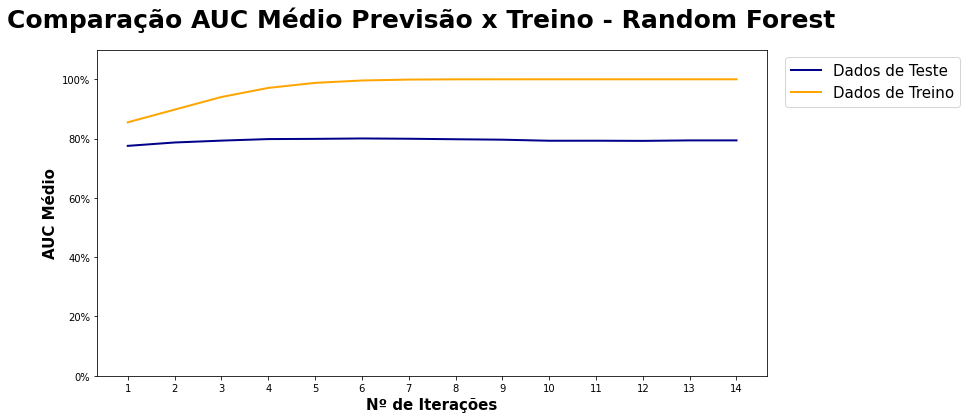

In [73]:
x = range(1,15)
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle('Comparação AUC Médio Previsão x Treino - Random Forest', fontsize = 25, fontweight='bold')
plt.plot(x, teste_lista, color = 'darkblue', lw = 2, label='Dados de Teste')
plt.plot(x, treino_lista, color = 'orange', lw = 2, label='Dados de Treino')
plt.xlabel('Nº de Iterações',
             fontsize=15, fontweight = 'bold')
plt.ylabel('AUC Médio',
             fontsize=15, fontweight = 'bold')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.00%}'))
plt.legend(fontsize = 15, loc='upper right',bbox_to_anchor=(1.3, 1))
plt.ylim(0,1.1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

No caso do **Random Forest**, temos um outro parâmetro que é bem importante para a realização de iterações que é o **`n_estimators`**, que dá o número de árvores da floresta. Quanto mais árvores, mais difícil de termos ***overfit***, mas mais demorado fica o treinamento do modelo.

O valor *default* é 100, mas vamos fazer alguns testes para verificar o impacto.

In [74]:
teste_lista = []
treino_lista = []

x = [10, 50, 100, 200]

for i in x:
    modelo_arvore_i = RandomForestClassifier(n_estimators=i)
    teste, treino = roda_modelo_cv_v3(modelo_arvore_i, dados_limpos, 5, 10)
    teste_lista.append(teste)
    treino_lista.append(treino)


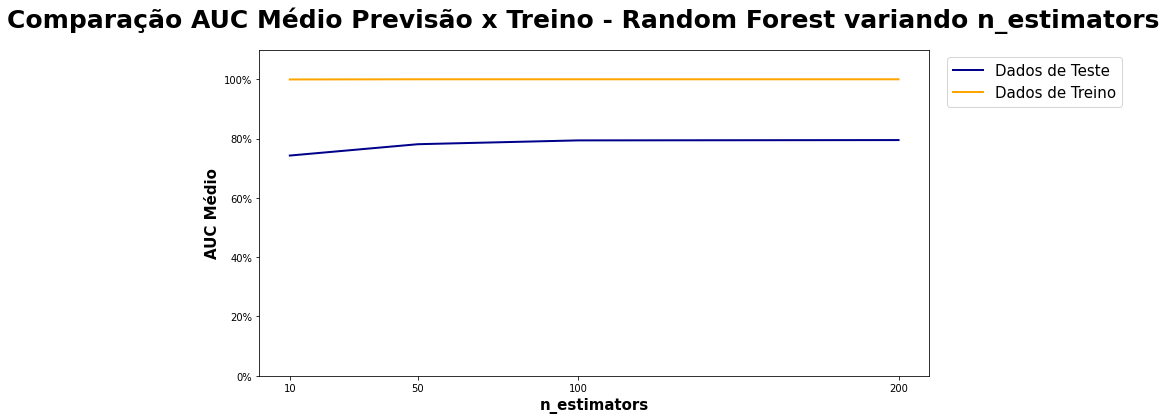

In [75]:
fig, ax = plt.subplots(figsize=(12,6))
plt.suptitle('Comparação AUC Médio Previsão x Treino - Random Forest variando n_estimators', fontsize = 25, fontweight='bold')
plt.plot(x, teste_lista, color = 'darkblue', lw = 2, label='Dados de Teste')
plt.plot(x, treino_lista, color = 'orange', lw = 2, label='Dados de Treino')
plt.xlabel('n_estimators',
             fontsize=15, fontweight = 'bold')
plt.ylabel('AUC Médio',
             fontsize=15, fontweight = 'bold')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.00%}'))
plt.legend(fontsize = 15, loc='upper right',bbox_to_anchor=(1.3, 1))
plt.ylim(0,1.1)
ax.xaxis.set_major_locator(ticker.FixedLocator(x))
plt.show()

#### **Desafio - Escolher um Modelo de *Machine Learning*, Estudar Seus Hiperparâmetros e Testar com Vários Valores**
---

Thiago comentou que dentro da documentação do **`sklearn`** tem maneiras de encontrar os melhores parâmetros para o modelo, em vez de ficar rodando repetidas vezes.

#### **Desafio - Pesquisar Como Salvar um Modelo Treinado**
---


Encontrei duas maneiras [aqui](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/).

Usando o ***pickle***:

In [67]:
import pickle

filename = 'modelo_arvore_final_pi.sav'
pickle.dump(modelo_arvore, open(filename, 'wb'))

Ou usando o ***joblib***:

In [68]:
import joblib

filename = 'modelo_arvore_final_jl.sav'
joblib.dump(modelo_arvore, filename)

['modelo_arvore_final_jl.sav']

### **O que aprendemos nessa aula?**
---

>* O que é ***Overfit***;
>
>* Como Verificar o ***Overfit***;
>
>* Usar o Algoritmo de ***RandomForest***.

---
